In [167]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
from statsmodels.tools.tools import add_constant
import os

# Sklearn
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split

# Helper Functions
from function import date_time_convertion, list_to_cols
import warnings
warnings.filterwarnings('ignore')

# Getting Started

1. Download the data, if not already in the current directory
Wget may not work, so visit https://drive.google.com/file/d/1qe5hOSBxzIuxBb1G_Ih5X-O65QElollE/view?usp=sharing to downlaod the data from google drive

In [168]:
if 'KuaiRec 2.0' not in os.listdir() and 'data' not in os.listdir():
    # !wget 'https://docs.google.com/uc?export=download&id=1qe5hOSBxzIuxBb1G_Ih5X-O65QElollE' --no-check-certificate -O data.zip
    print('Data file not found!')
    if 'KuaiRec.zip' in os.listdir():
        print('Zipfile found. Unziping')
        !unzip 'KuaiRec.zip' -d ./

2. Switch to the KuaiRec directory

In [169]:
DIR = "KuaiRec 2.0/"
if 'data' not in os.listdir():
    os.chdir(DIR)
rootpath="./"
print(rootpath)

./


In [170]:
# print("Loading big matrix...")
# big_matrix = pd.read_csv(rootpath + "data/big_matrix.csv")
print("Loading small matrix...")
small_matrix = pd.read_csv(rootpath + "data/small_matrix.csv")

print("Loading social network...")
social_network = pd.read_csv(rootpath + "data/social_network.csv")
social_network["friend_list"] = social_network["friend_list"].map(eval)

print("Loading item features...")
item_categories = pd.read_csv(rootpath + "data/item_categories.csv")
item_categories["feat"] = item_categories["feat"].map(eval)

print("Loading user features...")
user_features = pd.read_csv("data/user_features.csv")

print("Loading items' daily features...")
item_daily_features = pd.read_csv("data/item_daily_features.csv")

print("Loading video category...")
video_categories = pd.read_csv("data/kuairec_caption_category.csv",
                               engine="python",
                               usecols=["video_id",
                                        "first_level_category_id",
                                        "second_level_category_id",
                                        "third_level_category_id"]
                              )
user_features = pd.read_csv("data/user_features.csv", usecols=[0] + list(range(13, 31)))

print("All data loaded.")

Loading small matrix...
Loading social network...
Loading item features...
Loading user features...
Loading items' daily features...
Loading video category...
All data loaded.


## Data Exploration

Since we are mainly work with small_matrix our explorations are going to focus on that dataset.

In [171]:
small_matrix.head()

,user_id,video_id,play_duration,video_duration,time,date,timestamp,watch_ratio
0,14,148,4381,6067,2020-07-05 05:27:48.378,20200705.0,1.593898e+09,0.722103
1,14,183,11635,6100,2020-07-05 05:28:00.057,20200705.0,1.593898e+09,1.907377
2,14,3649,22422,10867,2020-07-05 05:29:09.479,20200705.0,1.593898e+09,2.063311
3,14,5262,4479,7908,2020-07-05 05:30:43.285,20200705.0,1.593898e+09,0.566388
4,14,8234,4602,11000,2020-07-05 05:35:43.459,20200705.0,1.593899e+09,0.418364


In [172]:
# sum([True for idx, row in small_matrix.iterrows() if any(row.isnull())])
print(f"Small Matrix shape: {small_matrix.shape}")
rows_wnans = small_matrix.shape[0] - small_matrix.dropna().shape[0]
print(f"There are {rows_wnans} rows with NaNs")

Small Matrix shape: (4676570, 8)
There are 181992 rows with NaNs


Since there are 181991 rows that have NaNs we will impute them in order not to lose valuable data. We could the compare how our results differe if we were to only drop these rows or impute them.

In [173]:
video_categories.head()

,video_id,first_level_category_id,second_level_category_id,third_level_category_id
0,0,8.0,673.0,-124.0
1,1,27.0,-124.0,-124.0
2,2,9.0,727.0,-124.0
3,3,26.0,686.0,2434.0
4,4,5.0,737.0,2596.0


In [174]:
video_categories.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10732 entries, 0 to 10731
Data columns (total 4 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   video_id                  10731 non-null  object 
 1   first_level_category_id   10728 non-null  float64
 2   second_level_category_id  10728 non-null  float64
 3   third_level_category_id   10724 non-null  float64
dtypes: float64(3), object(1)
memory usage: 335.5+ KB


In [175]:
print(len(video_categories["video_id"].unique()))

10731


In [176]:
user_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7176 entries, 0 to 7175
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   user_id        7176 non-null   int64  
 1   onehot_feat0   7176 non-null   int64  
 2   onehot_feat1   7176 non-null   int64  
 3   onehot_feat2   7176 non-null   int64  
 4   onehot_feat3   7176 non-null   int64  
 5   onehot_feat4   6975 non-null   float64
 6   onehot_feat5   7176 non-null   int64  
 7   onehot_feat6   7176 non-null   int64  
 8   onehot_feat7   7176 non-null   int64  
 9   onehot_feat8   7176 non-null   int64  
 10  onehot_feat9   7176 non-null   int64  
 11  onehot_feat10  7176 non-null   int64  
 12  onehot_feat11  7176 non-null   int64  
 13  onehot_feat12  7099 non-null   float64
 14  onehot_feat13  7101 non-null   float64
 15  onehot_feat14  7101 non-null   float64
 16  onehot_feat15  7102 non-null   float64
 17  onehot_feat16  7102 non-null   float64
 18  onehot_f

In [177]:
user_features.isna().sum()

user_id            0
onehot_feat0       0
onehot_feat1       0
onehot_feat2       0
onehot_feat3       0
onehot_feat4     201
onehot_feat5       0
onehot_feat6       0
onehot_feat7       0
onehot_feat8       0
onehot_feat9       0
onehot_feat10      0
onehot_feat11      0
onehot_feat12     77
onehot_feat13     75
onehot_feat14     75
onehot_feat15     74
onehot_feat16     74
onehot_feat17     74
dtype: int64

In [178]:
user_features.drop(['onehot_feat4', 'onehot_feat12',
                    'onehot_feat13', 'onehot_feat14',
                   'onehot_feat15', 'onehot_feat16', 'onehot_feat17'], axis=1, inplace=True)

In [179]:
user_features.isna().sum()

user_id          0
onehot_feat0     0
onehot_feat1     0
onehot_feat2     0
onehot_feat3     0
onehot_feat5     0
onehot_feat6     0
onehot_feat7     0
onehot_feat8     0
onehot_feat9     0
onehot_feat10    0
onehot_feat11    0
dtype: int64

## Data Preparation

#### Convert Date time to integers

In [180]:
import pandas as pd
import numpy as np
import datetime as dt

def date_time_convertion(col):
    col = pd.to_datetime(col)
    min_col = col.min()
    for idx, value in enumerate(col):
        new_val = (value - min_col).total_seconds()
        col.iloc[idx] = new_val
    return col

small_matrix["time"] = date_time_convertion(small_matrix["time"])

#### Process NaN

In [181]:
# Keep only rows with numeric "video_id"
video_categories = video_categories[video_categories["video_id"].astype(str).str.isnumeric()]

In [182]:
video_categories.loc[:, "video_id"] = video_categories["video_id"].astype(int)

In [183]:
print(len(video_categories["video_id"].unique()))

10728


In [184]:
video_categories.isna().sum()

video_id                    0
first_level_category_id     4
second_level_category_id    4
third_level_category_id     4
dtype: int64

In [185]:
np.sort(video_categories["first_level_category_id"].unique())

array([-124.,    1.,    2.,    3.,    4.,    5.,    6.,    7.,    8.,
          9.,   10.,   11.,   12.,   13.,   14.,   15.,   16.,   17.,
         18.,   19.,   20.,   21.,   22.,   23.,   24.,   25.,   26.,
         27.,   28.,   29.,   31.,   32.,   33.,   34.,   35.,   36.,
         37.,   38.,   39.,   nan])

In [186]:
np.sort(video_categories["second_level_category_id"].unique())

array([-124.,  110.,  115.,  118.,  119.,  126.,  128.,  129.,  130.,
        136.,  147.,  153.,  154.,  155.,  160.,  161.,  162.,  163.,
        167.,  168.,  169.,  170.,  179.,  195.,  201.,  203.,  204.,
        213.,  214.,  220.,  223.,  224.,  232.,  233.,  235.,  263.,
        264.,  267.,  268.,  270.,  271.,  272.,  292.,  314.,  317.,
        318.,  319.,  324.,  325.,  327.,  330.,  341.,  347.,  348.,
        352.,  354.,  368.,  372.,  373.,  374.,  386.,  387.,  389.,
        402.,  418.,  545.,  548.,  561.,  563.,  564.,  593.,  665.,
        666.,  667.,  670.,  672.,  673.,  674.,  675.,  677.,  678.,
        679.,  680.,  681.,  682.,  683.,  684.,  686.,  687.,  688.,
        689.,  690.,  691.,  692.,  693.,  694.,  695.,  696.,  697.,
        698.,  699.,  701.,  702.,  703.,  705.,  706.,  707.,  708.,
        711.,  712.,  713.,  714.,  715.,  716.,  717.,  718.,  719.,
        720.,  721.,  722.,  723.,  724.,  725.,  727.,  728.,  729.,
        732.,  733.,

### Replace NaN values with -124 (unknown)

In [187]:
# Replace NaN values with -124 (unknown)
video_categories.loc[:, ["first_level_category_id", "second_level_category_id", "third_level_category_id"]] = \
    video_categories[["first_level_category_id", "second_level_category_id", "third_level_category_id"]].fillna(-124)

In [188]:
video_categories.isna().sum()

video_id                    0
first_level_category_id     0
second_level_category_id    0
third_level_category_id     0
dtype: int64

In [189]:
video_categories.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10728 entries, 0 to 10731
Data columns (total 4 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   video_id                  10728 non-null  object 
 1   first_level_category_id   10728 non-null  float64
 2   second_level_category_id  10728 non-null  float64
 3   third_level_category_id   10728 non-null  float64
dtypes: float64(3), object(1)
memory usage: 419.1+ KB


#### Merge Datasets

In [358]:
# merge category IDs with the prepared dataset and create a new column "like" (1 if "watch_ratio" > 2 else 0)
small_matrix_merged = (
    small_matrix
    .merge(item_categories, on="video_id", how="left")
    .merge(video_categories[["video_id", "first_level_category_id", "second_level_category_id", "third_level_category_id"]], on = "video_id", how = "left")
)
small_matrix_merged['like'] = small_matrix_merged['watch_ratio'].apply(lambda x: 1 if x > 2 else 0)
display(small_matrix_merged)

,user_id,video_id,play_duration,video_duration,time,date,timestamp,watch_ratio,feat,first_level_category_id,second_level_category_id,third_level_category_id,like
0,14,148,4381,6067,97462.318,20200705.0,1.593898e+09,0.722103,"[11, 28, 19]",19.0,744.0,2636.0,0
1,14,183,11635,6100,97473.997,20200705.0,1.593898e+09,1.907377,[28],28.0,223.0,-124.0,0
2,14,3649,22422,10867,97543.419,20200705.0,1.593898e+09,2.063311,[9],28.0,223.0,1830.0,1
3,14,5262,4479,7908,97637.225,20200705.0,1.593898e+09,0.566388,[25],5.0,735.0,-124.0,0
4,14,8234,4602,11000,97937.399,20200705.0,1.593899e+09,0.418364,[6],6.0,667.0,2375.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4676565,7162,2267,11908,5467,NaN,NaN,NaN,2.178160,[25],25.0,235.0,1272.0,1
4676566,7162,2065,11919,6067,NaN,NaN,NaN,1.964562,"[9, 17]",29.0,689.0,2455.0,0
4676567,7162,1296,16690,19870,NaN,NaN,NaN,0.839960,"[1, 5]",1.0,722.0,2544.0,0
4676568,7162,4822,11862,24400,NaN,NaN,NaN,0.486148,[9],9.0,136.0,-124.0,0


In [359]:
# check if there is any nan values
small_matrix_merged.isna().sum()

user_id                          0
video_id                         0
play_duration                    0
video_duration                   0
time                        181992
date                        181992
timestamp                   181992
watch_ratio                      0
feat                             0
first_level_category_id          0
second_level_category_id         0
third_level_category_id          0
like                             0
dtype: int64

In [360]:
small_matrix_merged = list_to_cols(small_matrix_merged, "feat")

#### Data Imputation

In [361]:
# Median/Mean/Mode Imputation
for col in small_matrix_merged.columns:
    small_matrix_merged[col] = small_matrix_merged[col].fillna(small_matrix_merged[col].median()) # median() or mode()[0]
display(small_matrix_merged)    

,user_id,video_id,play_duration,video_duration,time,date,timestamp,watch_ratio,first_level_category_id,second_level_category_id,third_level_category_id,like,feat_1,feat_2,feat_3,feat_4
0,14,148,4381,6067,97462.318,20200705.0,1.593898e+09,0.722103,19.0,744.0,2636.0,0,11,28.0,19.0,0.0
1,14,183,11635,6100,97473.997,20200705.0,1.593898e+09,1.907377,28.0,223.0,-124.0,0,28,0.0,0.0,0.0
2,14,3649,22422,10867,97543.419,20200705.0,1.593898e+09,2.063311,28.0,223.0,1830.0,1,9,0.0,0.0,0.0
3,14,5262,4479,7908,97637.225,20200705.0,1.593898e+09,0.566388,5.0,735.0,-124.0,0,25,0.0,0.0,0.0
4,14,8234,4602,11000,97937.399,20200705.0,1.593899e+09,0.418364,6.0,667.0,2375.0,0,6,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4676565,7162,2267,11908,5467,2423337.210,20200801.0,1.596224e+09,2.178160,25.0,235.0,1272.0,1,25,0.0,0.0,0.0
4676566,7162,2065,11919,6067,2423337.210,20200801.0,1.596224e+09,1.964562,29.0,689.0,2455.0,0,9,17.0,0.0,0.0
4676567,7162,1296,16690,19870,2423337.210,20200801.0,1.596224e+09,0.839960,1.0,722.0,2544.0,0,1,5.0,0.0,0.0
4676568,7162,4822,11862,24400,2423337.210,20200801.0,1.596224e+09,0.486148,9.0,136.0,-124.0,0,9,0.0,0.0,0.0


# 1. First level category prediction: 38 arms

#### Data transformation

In [362]:
# normalise a dataframe such that each entry R_ij of row i column j becomes R_ij/(sum of row i)
def normalize_df(df):
    df_normalized = df.copy()
    
    for idx, row in df_normalized.iterrows():
        row_sum = row.sum()  # Sum of all values in the row
        if row_sum != 0:  # Avoid division by zero
            df_normalized.loc[idx] = row / row_sum  # Normalize by dividing each entry by the sum
    return df_normalized

In [363]:
# create dataframe with reward defined as mean of "like"
small_transformed_like_mean_df = small_matrix_merged.pivot_table(index='user_id', 
                                           columns='first_level_category_id', 
                                           values='like', 
                                           aggfunc='mean')
# create dataframe with reward defined as sum of "like"
small_transformed_like_sum_df = small_matrix_merged.pivot_table(index='user_id', 
                                           columns='first_level_category_id', 
                                           values='like', 
                                           aggfunc='sum')
# create dataframe with reward defined as mean of "watch_ratio"
small_transformed_WR_mean_df = small_matrix_merged.pivot_table(index='user_id', 
                                           columns='first_level_category_id', 
                                           values='watch_ratio', 
                                           aggfunc='mean')
# create dataframe with reward defined as sum of "watch_ratio"
small_transformed_WR_sum_df = small_matrix_merged.pivot_table(index='user_id', 
                                           columns='first_level_category_id', 
                                           values='watch_ratio', 
                                           aggfunc='sum')  

In [364]:
# create dataframe with reward defined as normalized mean of "like"
small_transformed_like_mean_normalized_df = normalize_df(small_transformed_like_mean_df)
# create dataframe with reward defined as normalized sum of "like"
small_transformed_like_sum_normalized_df = normalize_df(small_transformed_like_sum_df)
# create dataframe with reward defined as normalized mean of "watch_ratio"
small_transformed_WR_mean_normalized_df = normalize_df(small_transformed_WR_mean_df)
# create dataframe with reward defined as normalized sum of "watch_ratio"
small_transformed_WR_sum_normalized_df = normalize_df(small_transformed_WR_sum_df)

In [365]:
display(small_transformed_like_mean_df.head())
display(small_transformed_like_sum_df.head())
display(small_transformed_WR_mean_df.head())
display(small_transformed_WR_sum_df.head())

first_level_category_id,-124.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,...,29.0,31.0,32.0,33.0,34.0,35.0,36.0,37.0,38.0,39.0
user_id,,,,,,,,,,,,,,,,,,,,,
14,0.0,0.059259,0.041667,0.000,0.000000,0.088710,0.040816,0.096296,0.034364,0.068376,...,0.026316,0.020833,0.019231,0.044444,0.033149,0.000000,0.0,0.000000,0.0,0.1
19,0.0,0.014815,0.000000,0.000,0.000000,0.024194,0.004082,0.029630,0.013793,0.008547,...,0.000000,0.000000,0.019231,0.011111,0.005556,0.028571,0.0,0.000000,0.0,0.0
21,0.0,0.029630,0.083333,0.125,0.000000,0.032258,0.037975,0.044444,0.027491,0.008547,...,0.000000,0.020833,0.019231,0.033333,0.033149,0.057143,0.0,0.000000,0.0,0.0
23,0.0,0.074074,0.208333,0.125,0.033333,0.154472,0.086777,0.177778,0.134948,0.120690,...,0.078947,0.062500,0.057692,0.122222,0.110497,0.294118,0.0,0.181818,0.0,0.1
24,0.0,0.037037,0.041667,0.125,0.200000,0.096774,0.073770,0.103704,0.130584,0.043103,...,0.052632,0.083333,0.019608,0.077778,0.100559,0.085714,0.0,0.181818,0.0,0.1


first_level_category_id,-124.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,...,29.0,31.0,32.0,33.0,34.0,35.0,36.0,37.0,38.0,39.0
user_id,,,,,,,,,,,,,,,,,,,,,
14,0,8,1,0,0,11,10,13,10,8,...,1,1,1,4,6,0,0,0,0,1
19,0,2,0,0,0,3,1,4,4,1,...,0,0,1,1,1,1,0,0,0,0
21,0,4,2,1,0,4,9,6,8,1,...,0,1,1,3,6,2,0,0,0,0
23,0,10,5,1,1,19,21,24,39,14,...,3,3,3,11,20,10,0,2,0,1
24,0,5,1,1,6,12,18,14,38,5,...,2,4,1,7,18,3,0,2,0,1


first_level_category_id,-124.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,...,29.0,31.0,32.0,33.0,34.0,35.0,36.0,37.0,38.0,39.0
user_id,,,,,,,,,,,,,,,,,,,,,
14,1.071521,1.060108,0.782533,0.498848,0.773499,1.027956,0.923224,1.141082,0.941845,0.897101,...,0.764667,1.110412,0.543930,0.961673,1.046287,0.975852,0.628321,0.915659,1.373630,1.620472
19,0.727135,0.850105,0.627807,0.609756,0.870187,0.891233,0.752637,0.927754,0.897302,0.785999,...,0.668774,0.960513,0.482923,0.877022,0.795259,0.994846,0.569519,0.722029,0.501530,0.622001
21,0.731585,0.919334,0.967939,0.703035,0.916071,1.049959,1.013316,1.051918,0.996442,0.800017,...,0.663281,1.025110,0.469865,0.939669,0.856538,0.960484,0.714403,0.911087,0.638147,0.676194
23,0.995418,0.793092,1.109817,0.772646,0.688310,1.072276,0.791424,1.141803,1.096890,1.073848,...,0.830184,0.863781,0.556025,1.057947,0.832558,1.561493,0.576984,1.049925,0.617669,0.555079
24,0.671036,0.661579,0.560935,0.667768,0.884266,1.069469,0.731593,0.840489,1.112095,0.787373,...,0.497834,0.982327,0.464740,0.850890,0.765056,0.804141,0.538142,1.137524,0.663112,0.800160


first_level_category_id,-124.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,...,29.0,31.0,32.0,33.0,34.0,35.0,36.0,37.0,38.0,39.0
user_id,,,,,,,,,,,,,,,,,,,,,
14,4.286082,143.114573,18.780785,3.990782,23.204983,127.466564,226.189900,154.046108,274.076947,104.960823,...,29.057355,53.299769,28.284356,86.550536,189.378020,34.154832,5.654891,10.072252,2.747260,16.204715
19,2.181404,114.764137,15.067363,4.878045,26.105601,110.512886,184.396166,125.246851,260.217647,91.961913,...,25.413421,46.104619,25.111988,78.931972,143.146660,34.819603,5.125674,7.942315,1.003059,6.220014
21,2.926339,124.110059,23.230539,5.624282,27.482122,130.194884,240.155861,142.008902,289.964595,93.602000,...,25.204688,49.205301,24.432978,84.570179,155.033386,33.616927,6.429626,10.021961,1.276294,6.761944
23,3.981672,107.067355,26.635610,6.181167,20.649301,131.889982,191.524655,154.143455,317.001194,124.566335,...,31.547009,41.461490,28.913310,95.215205,150.692951,53.090773,5.192854,11.549175,1.235337,5.550794
24,2.684146,89.313163,13.462446,5.342142,26.527966,132.614202,178.508812,113.466052,323.619663,91.335295,...,18.917689,47.151678,23.701717,76.580128,136.945069,28.144926,4.843280,12.512766,1.326224,8.001600


In [366]:
display(small_transformed_like_mean_normalized_df.head())
display(small_transformed_like_sum_normalized_df.head())
display(small_transformed_WR_mean_normalized_df.head())
display(small_transformed_WR_sum_normalized_df.head())

first_level_category_id,-124.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,...,29.0,31.0,32.0,33.0,34.0,35.0,36.0,37.0,38.0,39.0
user_id,,,,,,,,,,,,,,,,,,,,,
14,0.0,0.035735,0.025126,0.000000,0.000000,0.053495,0.024613,0.058069,0.020723,0.041233,...,0.015869,0.012563,0.011597,0.026801,0.019990,0.000000,0.0,0.000000,0.0,0.060303
19,0.0,0.047183,0.000000,0.000000,0.000000,0.077054,0.013000,0.094367,0.043929,0.027221,...,0.000000,0.000000,0.061248,0.035388,0.017694,0.090997,0.0,0.000000,0.0,0.000000
21,0.0,0.029974,0.084301,0.126451,0.000000,0.032633,0.038416,0.044960,0.027811,0.008646,...,0.000000,0.021075,0.019454,0.033720,0.033534,0.057806,0.0,0.000000,0.0,0.000000
23,0.0,0.018804,0.052887,0.031732,0.008462,0.039214,0.022029,0.045130,0.034257,0.030638,...,0.020041,0.015866,0.014646,0.031027,0.028050,0.074664,0.0,0.046156,0.0,0.025386
24,0.0,0.011809,0.013286,0.039857,0.063771,0.030857,0.023522,0.033066,0.041637,0.013744,...,0.016782,0.026571,0.006252,0.024800,0.032064,0.027330,0.0,0.057974,0.0,0.031886


first_level_category_id,-124.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,...,29.0,31.0,32.0,33.0,34.0,35.0,36.0,37.0,38.0,39.0
user_id,,,,,,,,,,,,,,,,,,,,,
14,0.0,0.044693,0.005587,0.000000,0.000000,0.061453,0.055866,0.072626,0.055866,0.044693,...,0.005587,0.005587,0.005587,0.022346,0.033520,0.000000,0.0,0.000000,0.0,0.005587
19,0.0,0.050000,0.000000,0.000000,0.000000,0.075000,0.025000,0.100000,0.100000,0.025000,...,0.000000,0.000000,0.025000,0.025000,0.025000,0.025000,0.0,0.000000,0.0,0.000000
21,0.0,0.035714,0.017857,0.008929,0.000000,0.035714,0.080357,0.053571,0.071429,0.008929,...,0.000000,0.008929,0.008929,0.026786,0.053571,0.017857,0.0,0.000000,0.0,0.000000
23,0.0,0.023866,0.011933,0.002387,0.002387,0.045346,0.050119,0.057279,0.093079,0.033413,...,0.007160,0.007160,0.007160,0.026253,0.047733,0.023866,0.0,0.004773,0.0,0.002387
24,0.0,0.015198,0.003040,0.003040,0.018237,0.036474,0.054711,0.042553,0.115502,0.015198,...,0.006079,0.012158,0.003040,0.021277,0.054711,0.009119,0.0,0.006079,0.0,0.003040


first_level_category_id,-124.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,...,29.0,31.0,32.0,33.0,34.0,35.0,36.0,37.0,38.0,39.0
user_id,,,,,,,,,,,,,,,,,,,,,
14,0.030440,0.030116,0.022231,0.014172,0.021974,0.029203,0.026227,0.032416,0.026756,0.025485,...,0.021723,0.031545,0.015452,0.027320,0.029723,0.027723,0.017850,0.026013,0.039023,0.046035
19,0.025659,0.029998,0.022154,0.021517,0.030707,0.031449,0.026559,0.032738,0.031664,0.027736,...,0.023599,0.033894,0.017041,0.030948,0.028063,0.035106,0.020097,0.025479,0.017698,0.021949
21,0.022868,0.028737,0.030257,0.021976,0.028635,0.032820,0.031675,0.032882,0.031148,0.025008,...,0.020733,0.032044,0.014687,0.029373,0.026774,0.030024,0.022331,0.028479,0.019948,0.021137
23,0.029239,0.023296,0.032599,0.022695,0.020218,0.031496,0.023247,0.033538,0.032219,0.031542,...,0.024385,0.025372,0.016332,0.031075,0.024455,0.045866,0.016948,0.030840,0.018143,0.016304
24,0.023623,0.023291,0.019747,0.023508,0.031130,0.037650,0.025755,0.029589,0.039151,0.027719,...,0.017526,0.034582,0.016361,0.029955,0.026933,0.028309,0.018945,0.040046,0.023344,0.028169


first_level_category_id,-124.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,...,29.0,31.0,32.0,33.0,34.0,35.0,36.0,37.0,38.0,39.0
user_id,,,,,,,,,,,,,,,,,,,,,
14,0.001293,0.043188,0.005668,0.001204,0.007003,0.038466,0.068259,0.046487,0.082710,0.031675,...,0.008769,0.016085,0.008536,0.026119,0.057150,0.010307,0.001707,0.003040,0.000829,0.004890
19,0.000787,0.041418,0.005438,0.001760,0.009421,0.039884,0.066548,0.045201,0.093912,0.033189,...,0.009172,0.016639,0.009063,0.028486,0.051661,0.012566,0.001850,0.002866,0.000362,0.002245
21,0.000934,0.039603,0.007413,0.001795,0.008769,0.041544,0.076632,0.045314,0.092525,0.029868,...,0.008043,0.015701,0.007796,0.026986,0.049470,0.010727,0.002052,0.003198,0.000407,0.002158
23,0.001176,0.031631,0.007869,0.001826,0.006100,0.038964,0.056582,0.045539,0.093652,0.036801,...,0.009320,0.012249,0.008542,0.028129,0.044519,0.015685,0.001534,0.003412,0.000365,0.001640
24,0.000937,0.031179,0.004700,0.001865,0.009261,0.046295,0.062317,0.039611,0.112975,0.031885,...,0.006604,0.016461,0.008274,0.026734,0.047807,0.009825,0.001691,0.004368,0.000463,0.002793


In [367]:
transformed_dfs = [small_transformed_like_mean_df, small_transformed_like_sum_df, 
                   small_transformed_WR_mean_df, small_transformed_WR_sum_df]
transformed_normalized_dfs = [small_transformed_like_mean_normalized_df, small_transformed_like_sum_normalized_df, 
                             small_transformed_WR_mean_normalized_df, small_transformed_WR_sum_normalized_df]
transformed_dfs_label = ["mean of like", "sum of like", "mean of watch_ratio", "sum of watch_ratio"]
transformed_normalized_dfs_label = ["mean of like normalized", "sum of like normalized", 
                                    "mean of watch_ratio normalized", "sum of watch_ratio normalized"]

In [368]:
# Merge the reward dataframe with user_features (used as context vector), add a constant column, and set 'user_id' as index
def process_df(df):
    df = user_features.merge(df, on="user_id", how="right")  # Merge with user_features
    df.set_index('user_id', inplace=True)  # Set 'user_id' as index
    df = add_constant(df)  # Add a constant column
    return df

for i in range(len(transformed_dfs)):
    transformed_dfs[i] = process_df(transformed_dfs[i])

for i in range(len(transformed_normalized_dfs)):
    transformed_normalized_dfs[i] = process_df(transformed_normalized_dfs[i])


In [369]:
for df in transformed_dfs:
    display(df.head())

,const,onehot_feat0,onehot_feat1,onehot_feat2,onehot_feat3,onehot_feat5,onehot_feat6,onehot_feat7,onehot_feat8,onehot_feat9,...,29.0,31.0,32.0,33.0,34.0,35.0,36.0,37.0,38.0,39.0
user_id,,,,,,,,,,,,,,,,,,,,,
14,1.0,0,5,8,417,0,1,3,297,4,...,0.026316,0.020833,0.019231,0.044444,0.033149,0.000000,0.0,0.000000,0.0,0.1
19,1.0,0,1,18,589,0,1,7,227,3,...,0.000000,0.000000,0.019231,0.011111,0.005556,0.028571,0.0,0.000000,0.0,0.0
21,1.0,0,4,13,568,0,0,13,292,4,...,0.000000,0.020833,0.019231,0.033333,0.033149,0.057143,0.0,0.000000,0.0,0.0
23,1.0,0,1,3,45,0,0,13,148,6,...,0.078947,0.062500,0.057692,0.122222,0.110497,0.294118,0.0,0.181818,0.0,0.1
24,1.0,1,4,17,634,0,1,0,64,5,...,0.052632,0.083333,0.019608,0.077778,0.100559,0.085714,0.0,0.181818,0.0,0.1


,const,onehot_feat0,onehot_feat1,onehot_feat2,onehot_feat3,onehot_feat5,onehot_feat6,onehot_feat7,onehot_feat8,onehot_feat9,...,29.0,31.0,32.0,33.0,34.0,35.0,36.0,37.0,38.0,39.0
user_id,,,,,,,,,,,,,,,,,,,,,
14,1.0,0,5,8,417,0,1,3,297,4,...,1,1,1,4,6,0,0,0,0,1
19,1.0,0,1,18,589,0,1,7,227,3,...,0,0,1,1,1,1,0,0,0,0
21,1.0,0,4,13,568,0,0,13,292,4,...,0,1,1,3,6,2,0,0,0,0
23,1.0,0,1,3,45,0,0,13,148,6,...,3,3,3,11,20,10,0,2,0,1
24,1.0,1,4,17,634,0,1,0,64,5,...,2,4,1,7,18,3,0,2,0,1


,const,onehot_feat0,onehot_feat1,onehot_feat2,onehot_feat3,onehot_feat5,onehot_feat6,onehot_feat7,onehot_feat8,onehot_feat9,...,29.0,31.0,32.0,33.0,34.0,35.0,36.0,37.0,38.0,39.0
user_id,,,,,,,,,,,,,,,,,,,,,
14,1.0,0,5,8,417,0,1,3,297,4,...,0.764667,1.110412,0.543930,0.961673,1.046287,0.975852,0.628321,0.915659,1.373630,1.620472
19,1.0,0,1,18,589,0,1,7,227,3,...,0.668774,0.960513,0.482923,0.877022,0.795259,0.994846,0.569519,0.722029,0.501530,0.622001
21,1.0,0,4,13,568,0,0,13,292,4,...,0.663281,1.025110,0.469865,0.939669,0.856538,0.960484,0.714403,0.911087,0.638147,0.676194
23,1.0,0,1,3,45,0,0,13,148,6,...,0.830184,0.863781,0.556025,1.057947,0.832558,1.561493,0.576984,1.049925,0.617669,0.555079
24,1.0,1,4,17,634,0,1,0,64,5,...,0.497834,0.982327,0.464740,0.850890,0.765056,0.804141,0.538142,1.137524,0.663112,0.800160


,const,onehot_feat0,onehot_feat1,onehot_feat2,onehot_feat3,onehot_feat5,onehot_feat6,onehot_feat7,onehot_feat8,onehot_feat9,...,29.0,31.0,32.0,33.0,34.0,35.0,36.0,37.0,38.0,39.0
user_id,,,,,,,,,,,,,,,,,,,,,
14,1.0,0,5,8,417,0,1,3,297,4,...,29.057355,53.299769,28.284356,86.550536,189.378020,34.154832,5.654891,10.072252,2.747260,16.204715
19,1.0,0,1,18,589,0,1,7,227,3,...,25.413421,46.104619,25.111988,78.931972,143.146660,34.819603,5.125674,7.942315,1.003059,6.220014
21,1.0,0,4,13,568,0,0,13,292,4,...,25.204688,49.205301,24.432978,84.570179,155.033386,33.616927,6.429626,10.021961,1.276294,6.761944
23,1.0,0,1,3,45,0,0,13,148,6,...,31.547009,41.461490,28.913310,95.215205,150.692951,53.090773,5.192854,11.549175,1.235337,5.550794
24,1.0,1,4,17,634,0,1,0,64,5,...,18.917689,47.151678,23.701717,76.580128,136.945069,28.144926,4.843280,12.512766,1.326224,8.001600


In [370]:
for df in transformed_normalized_dfs:
    display(df.head())

,const,onehot_feat0,onehot_feat1,onehot_feat2,onehot_feat3,onehot_feat5,onehot_feat6,onehot_feat7,onehot_feat8,onehot_feat9,...,29.0,31.0,32.0,33.0,34.0,35.0,36.0,37.0,38.0,39.0
user_id,,,,,,,,,,,,,,,,,,,,,
14,1.0,0,5,8,417,0,1,3,297,4,...,0.015869,0.012563,0.011597,0.026801,0.019990,0.000000,0.0,0.000000,0.0,0.060303
19,1.0,0,1,18,589,0,1,7,227,3,...,0.000000,0.000000,0.061248,0.035388,0.017694,0.090997,0.0,0.000000,0.0,0.000000
21,1.0,0,4,13,568,0,0,13,292,4,...,0.000000,0.021075,0.019454,0.033720,0.033534,0.057806,0.0,0.000000,0.0,0.000000
23,1.0,0,1,3,45,0,0,13,148,6,...,0.020041,0.015866,0.014646,0.031027,0.028050,0.074664,0.0,0.046156,0.0,0.025386
24,1.0,1,4,17,634,0,1,0,64,5,...,0.016782,0.026571,0.006252,0.024800,0.032064,0.027330,0.0,0.057974,0.0,0.031886


,const,onehot_feat0,onehot_feat1,onehot_feat2,onehot_feat3,onehot_feat5,onehot_feat6,onehot_feat7,onehot_feat8,onehot_feat9,...,29.0,31.0,32.0,33.0,34.0,35.0,36.0,37.0,38.0,39.0
user_id,,,,,,,,,,,,,,,,,,,,,
14,1.0,0,5,8,417,0,1,3,297,4,...,0.005587,0.005587,0.005587,0.022346,0.033520,0.000000,0.0,0.000000,0.0,0.005587
19,1.0,0,1,18,589,0,1,7,227,3,...,0.000000,0.000000,0.025000,0.025000,0.025000,0.025000,0.0,0.000000,0.0,0.000000
21,1.0,0,4,13,568,0,0,13,292,4,...,0.000000,0.008929,0.008929,0.026786,0.053571,0.017857,0.0,0.000000,0.0,0.000000
23,1.0,0,1,3,45,0,0,13,148,6,...,0.007160,0.007160,0.007160,0.026253,0.047733,0.023866,0.0,0.004773,0.0,0.002387
24,1.0,1,4,17,634,0,1,0,64,5,...,0.006079,0.012158,0.003040,0.021277,0.054711,0.009119,0.0,0.006079,0.0,0.003040


,const,onehot_feat0,onehot_feat1,onehot_feat2,onehot_feat3,onehot_feat5,onehot_feat6,onehot_feat7,onehot_feat8,onehot_feat9,...,29.0,31.0,32.0,33.0,34.0,35.0,36.0,37.0,38.0,39.0
user_id,,,,,,,,,,,,,,,,,,,,,
14,1.0,0,5,8,417,0,1,3,297,4,...,0.021723,0.031545,0.015452,0.027320,0.029723,0.027723,0.017850,0.026013,0.039023,0.046035
19,1.0,0,1,18,589,0,1,7,227,3,...,0.023599,0.033894,0.017041,0.030948,0.028063,0.035106,0.020097,0.025479,0.017698,0.021949
21,1.0,0,4,13,568,0,0,13,292,4,...,0.020733,0.032044,0.014687,0.029373,0.026774,0.030024,0.022331,0.028479,0.019948,0.021137
23,1.0,0,1,3,45,0,0,13,148,6,...,0.024385,0.025372,0.016332,0.031075,0.024455,0.045866,0.016948,0.030840,0.018143,0.016304
24,1.0,1,4,17,634,0,1,0,64,5,...,0.017526,0.034582,0.016361,0.029955,0.026933,0.028309,0.018945,0.040046,0.023344,0.028169


,const,onehot_feat0,onehot_feat1,onehot_feat2,onehot_feat3,onehot_feat5,onehot_feat6,onehot_feat7,onehot_feat8,onehot_feat9,...,29.0,31.0,32.0,33.0,34.0,35.0,36.0,37.0,38.0,39.0
user_id,,,,,,,,,,,,,,,,,,,,,
14,1.0,0,5,8,417,0,1,3,297,4,...,0.008769,0.016085,0.008536,0.026119,0.057150,0.010307,0.001707,0.003040,0.000829,0.004890
19,1.0,0,1,18,589,0,1,7,227,3,...,0.009172,0.016639,0.009063,0.028486,0.051661,0.012566,0.001850,0.002866,0.000362,0.002245
21,1.0,0,4,13,568,0,0,13,292,4,...,0.008043,0.015701,0.007796,0.026986,0.049470,0.010727,0.002052,0.003198,0.000407,0.002158
23,1.0,0,1,3,45,0,0,13,148,6,...,0.009320,0.012249,0.008542,0.028129,0.044519,0.015685,0.001534,0.003412,0.000365,0.001640
24,1.0,1,4,17,634,0,1,0,64,5,...,0.006604,0.016461,0.008274,0.026734,0.047807,0.009825,0.001691,0.004368,0.000463,0.002793


#### Train-Test Split

In [371]:
X_train = []
X_test = []
X_train_normalized = []
X_test_normalized = []

In [372]:
for df in transformed_dfs:
    train, test = train_test_split(df, test_size=0.18, random_state=2024, shuffle=True)
    X_train.append(train)
    X_test.append(test)
for df in transformed_normalized_dfs:
    train, test = train_test_split(df, test_size=0.18, random_state=2024, shuffle=True)
    X_train_normalized.append(train)
    X_test_normalized.append(test)

### MAB - LinUCB

In [375]:
class Linear_Bandit:
    def __init__(self, arms, features):
        self.K = arms 
        self.D = features
        self.params = np.random.rand(self.K, self.D+1)
    
    def gen_contexts(self):
        self.contexts = np.random.rand(self.K, self.D)
        self.contexts = add_constant(self.contexts)
        return self.contexts
    
    def pull_arm(self, i):
        return np.sum(self.contexts[i]*self.params[i]) + np.random.random()

    def compute_regret(self, i):
        all_rewards = np.sum(self.contexts * self.params, axis=1)
        return np.max(all_rewards) - all_rewards[i]

def compute_ucb(x, A, b, alpha):
    UCB = []
    for i in range(len(b)):
        Ainv = np.linalg.inv(A[i])
        Rhat = x @ Ainv @ b[i]
        Uhat = alpha * np.sqrt(x.T @ Ainv @ x)
        UCB.append(Rhat + Uhat)
    return np.array(UCB)

def linucb(alpha, trials, X, A = None, b = None, num_arm = 38, num_features = 11):
    K = num_arm
    D = num_features
    if A == None:
        A = [np.eye(D+1) for i in range(K)]
    if b == None:
        b = [np.zeros(D+1) for i in range(K)]
    regret = np.zeros(trials)
    values_of_idx = []
    
    for i in range(trials):
        # Get Data
        user = X.sample(n=1).values.flatten()
        x = user[:D+1]
        rewards = user[D+1:]
        
        # Pull Arm
        UCB = compute_ucb(x, A, b, alpha)
        idx = np.argmax(UCB)
        reward = rewards[idx]

        # Update A and b
        A[idx] += np.outer(x, x)
        b[idx] += reward * x

        # Compute Regret
        regret[i] = np.max(rewards) - reward
    return A, b, regret

# This function returns the regret when using pretrained weights A and b to pull an arm given a test dataset
def linucb_test(alpha, X, A = None, b = None, num_arm = 38, num_features = 11):
    K = num_arm
    D = num_features
    if A == None:
        A = [np.eye(D+1) for i in range(K)]
    if b == None:
        b = [np.zeros(D+1) for i in range(K)]
    regret = np.zeros(X.shape[0])
    values_of_idx = []
    
    i = 0
    for index, user in X.iterrows():
        # Get Data
        user = user.values.flatten()
        x = user[:D+1]
        rewards = user[D+1:]
        
        # Pull Arm
        UCB = compute_ucb(x, A, b, alpha)
        idx = np.argmax(UCB)
        reward = rewards[idx]
        
        # Compute Regret
        regret[i] = np.max(rewards) - reward
        i += 1
    return A, b, regret

# This function returns the arms pulled when using pretrained weights A and b to pull an arm given a test dataset
def predict(alpha, X, A = None, b = None, num_arm = 38, num_features = 11):
    K = num_arm
    D = num_features
    if A == None:
        A = [np.eye(D+1) for i in range(K)]
    if b == None:
        b = [np.zeros(D+1) for i in range(K)]
    regret = np.zeros(X.shape[0])
    values_of_idx = []
    prediction = []
    cat = X.columns[D+1:]
    
    i = 0
    for index, user in X.iterrows():
        # Get Data
        user = user.values.flatten()
        x = user[:D+1]
        rewards = user[D+1:]
        
        # Pull Arm
        UCB = compute_ucb(x, A, b, alpha)
        idx = np.argmax(UCB)
        reward = rewards[idx]

        # Compute Regret
        regret[i] = np.max(rewards) - reward
        prediction.append(cat[idx])
        i += 1
    return prediction

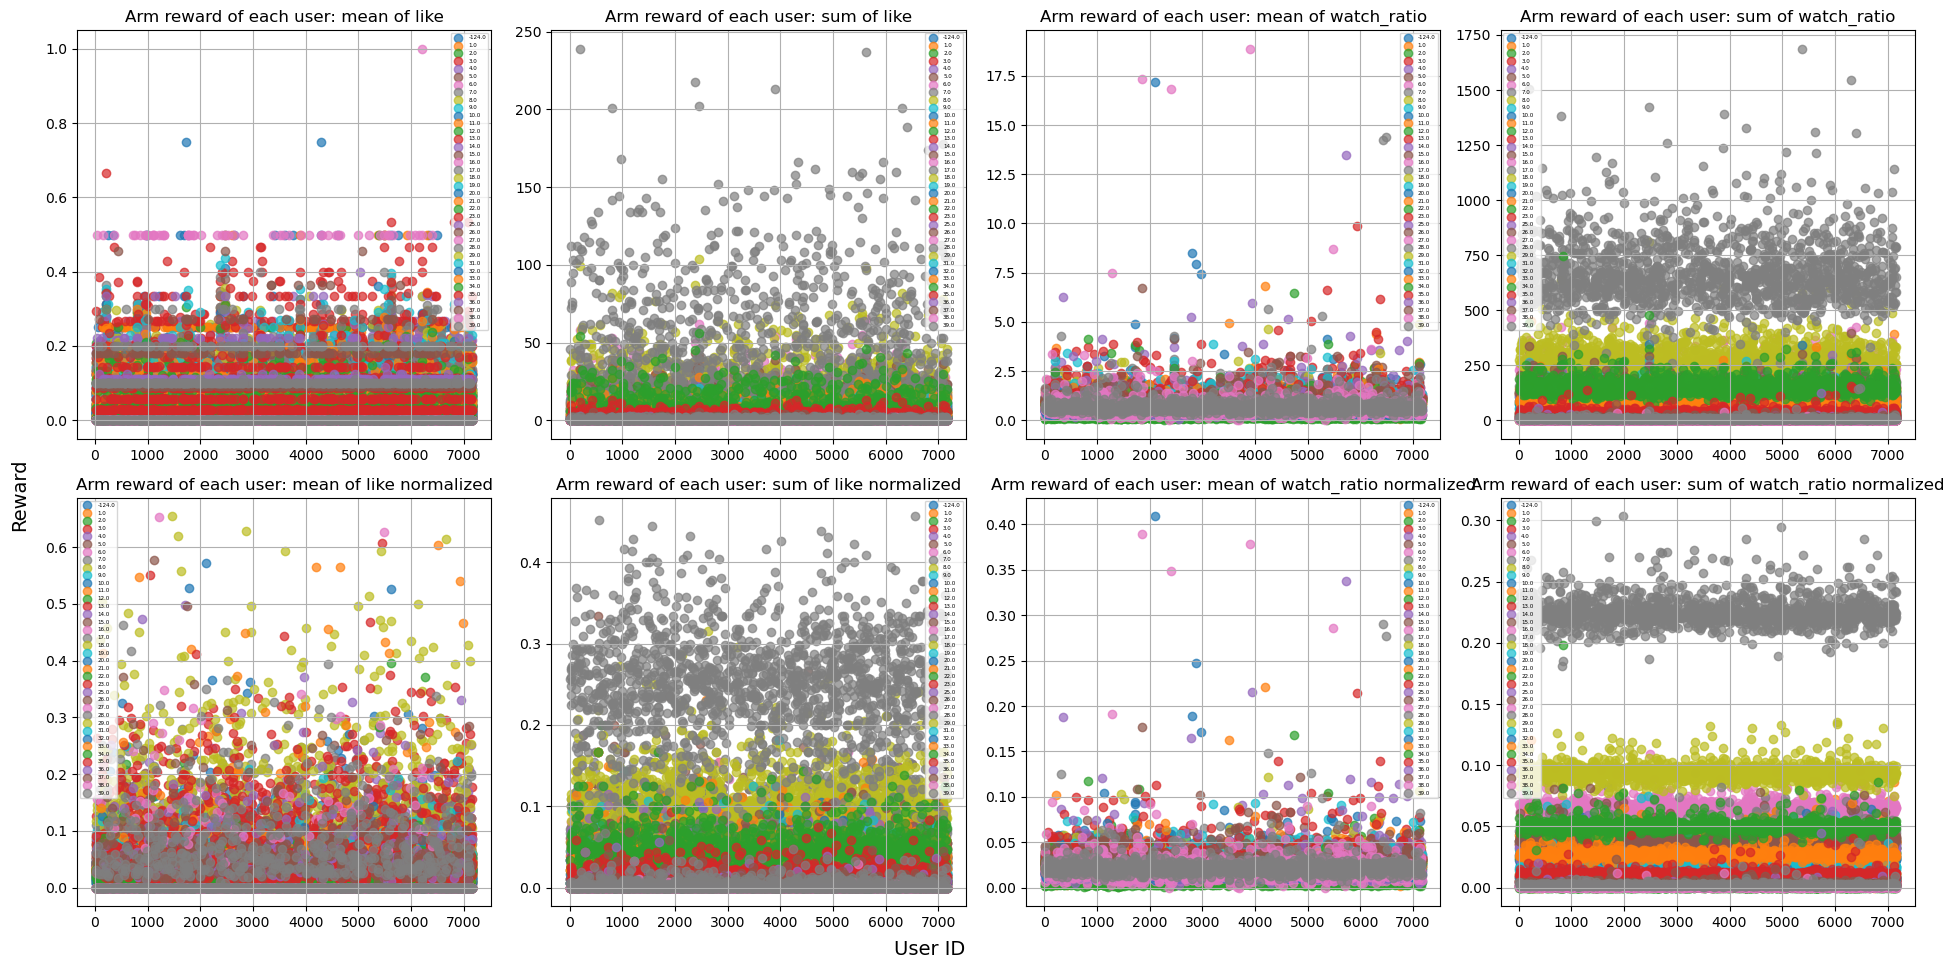

In [405]:
# Plots of different reward defintions

all_dfs = transformed_dfs + transformed_normalized_dfs
all_labels = transformed_dfs_label + transformed_normalized_dfs_label

# 2x4 subplot
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(20, 10), sharex=False, sharey=False)

axes = axes.flatten()

for i, (df, label) in enumerate(zip(all_dfs, all_labels)):
    ax = axes[i]
    filtered_df = df.iloc[:, 12:]
    for column in filtered_df.columns:
        ax.scatter(filtered_df.index, filtered_df[column], label=f"{column}", alpha=0.7)
    ax.set_title("Arm reward of each user: "+label, fontsize=12)
    ax.legend(fontsize=4)
    ax.grid(True)

fig.text(0.5, 0.04, "User ID", ha="center", fontsize=14)
fig.text(0.04, 0.5, "Reward", va="center", rotation="vertical", fontsize=14)

plt.tight_layout(rect=[0.05, 0.05, 1, 1])
plt.show()


In [337]:
arm_ids = small_matrix_merged["first_level_category_id"].unique()
print("Number of arms:", len(arm_ids))
print(np.sort(arm_ids))

Number of arms: 38
[-124.    1.    2.    3.    4.    5.    6.    7.    8.    9.   10.   11.
   12.   13.   14.   15.   16.   17.   18.   19.   20.   21.   22.   23.
   25.   26.   27.   28.   29.   31.   32.   33.   34.   35.   36.   37.
   38.   39.]


In [286]:
print("Number of context features:", user_features.shape[1]-1)

Number of context features: 11


In [378]:
print(X_train[0].shape)

(1157, 50)


In [402]:
# This function trains the LinUCB, test the trained LinUCB on a test dataset, and plot the results
def train_and_test(X, X_test, data_label, num_arm = 38, num_features = 11, trials = 1000, sims = 50, alpha = 1):
    avg_regret = np.zeros(trials)

    for m in range(sims):
        A_train, b_train, regret = linucb(alpha, trials, X, num_arm = num_arm, num_features = num_features)
        avg_regret += regret 
    avg_regret /= sims
    
    A_test, b_test, regret_test = linucb_test(alpha, X_test,
                                      A = A_train, b = b_train,
                                      num_arm = num_arm, num_features = num_features)
    pred = predict(alpha, X, A = A_train, b = b_train, num_arm = num_arm, num_features = num_features)
    
    fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(12, 12))

    # Plot Training cumulative regret
    axes[0].plot(np.cumsum(avg_regret), label="Training", color="blue")
    axes[0].set_title(f"Linear UCB - Training (Reward: {data_label})", fontsize=14)
    axes[0].set_xlabel("Time", fontsize=12)
    axes[0].set_ylabel("Cumulative Regret", fontsize=12)
    axes[0].legend()

    # Plot Testing cumulative regret
    axes[1].plot(np.cumsum(regret_test), label="Testing", color="orange")
    axes[1].set_title(f"Linear UCB - Testing (Reward: {data_label})", fontsize=14)
    axes[1].set_xlabel("Time", fontsize=12)
    axes[1].set_ylabel("Cumulative Regret", fontsize=12)
    axes[1].legend()
    
    # Plot frequency of arms pulled during testing
    axes[2].hist(pred, bins=len(np.unique(pred)), color="green", alpha=0.7, edgecolor="black")
    axes[2].set_title(f"Arms pulled in testing (Reward: {data_label})", fontsize=14)
    axes[2].set_xlabel("Arm", fontsize=12)
    axes[2].set_ylabel("Frequency", fontsize=12)
    axes[2].grid(True)

    plt.tight_layout()
    plt.show()

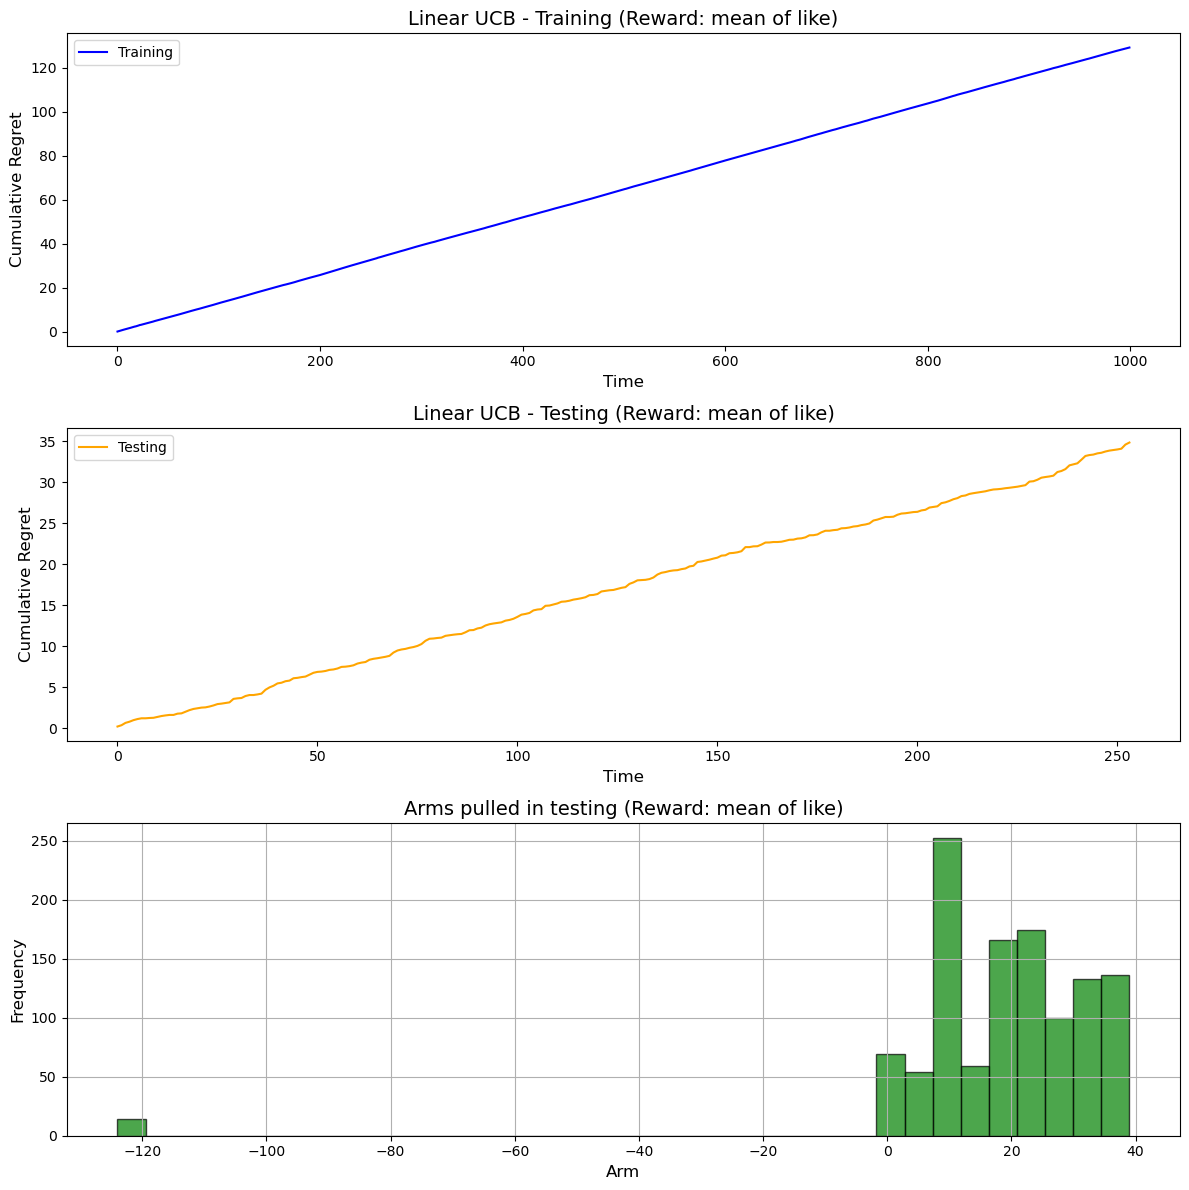

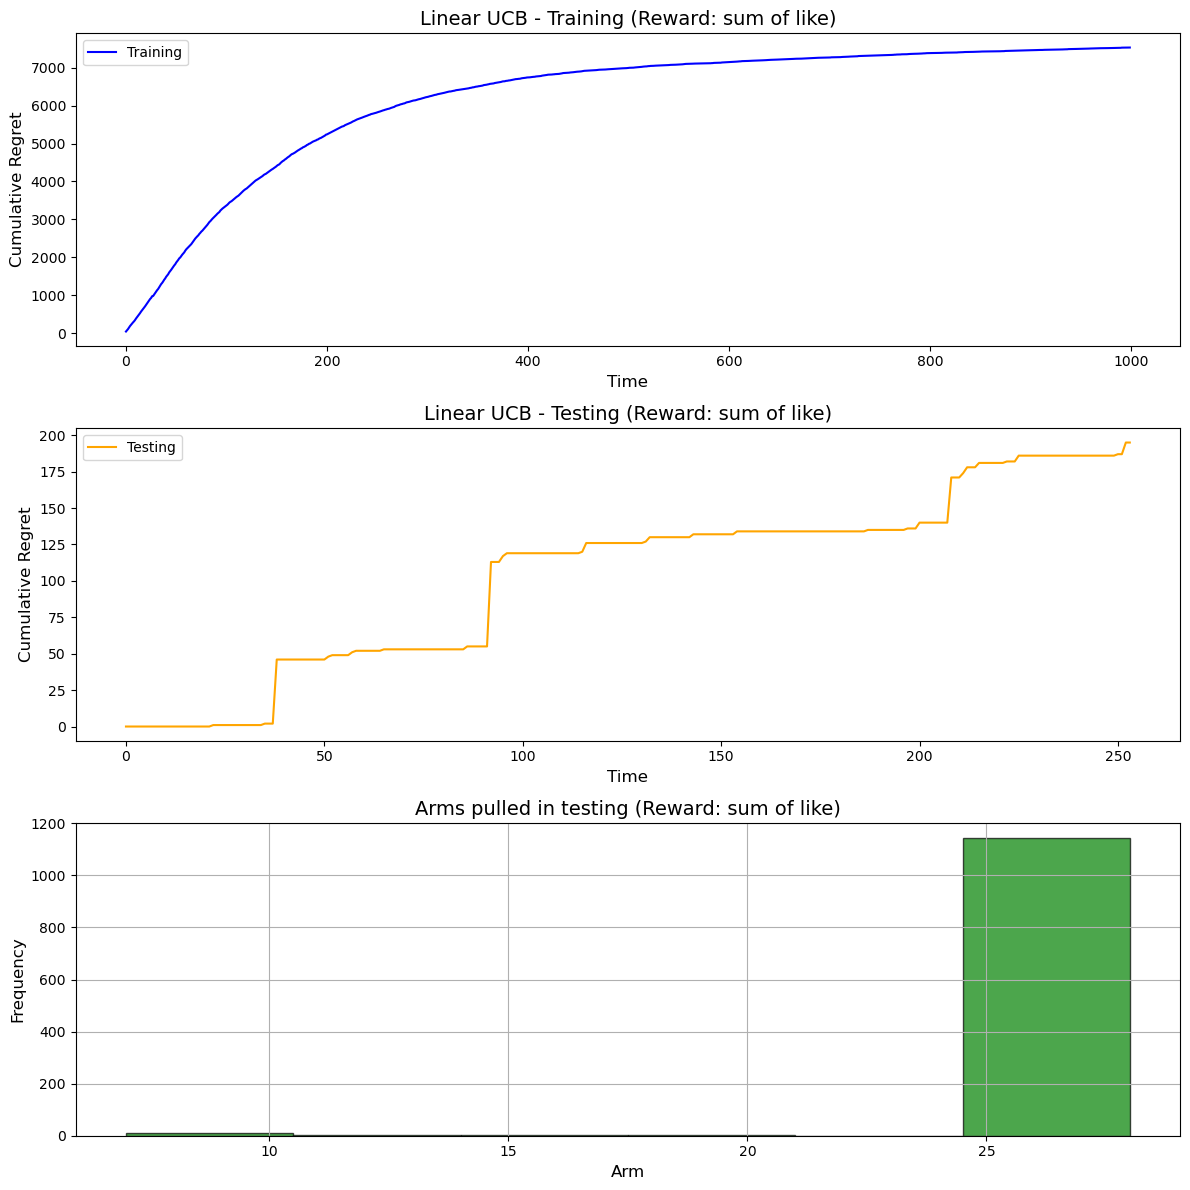

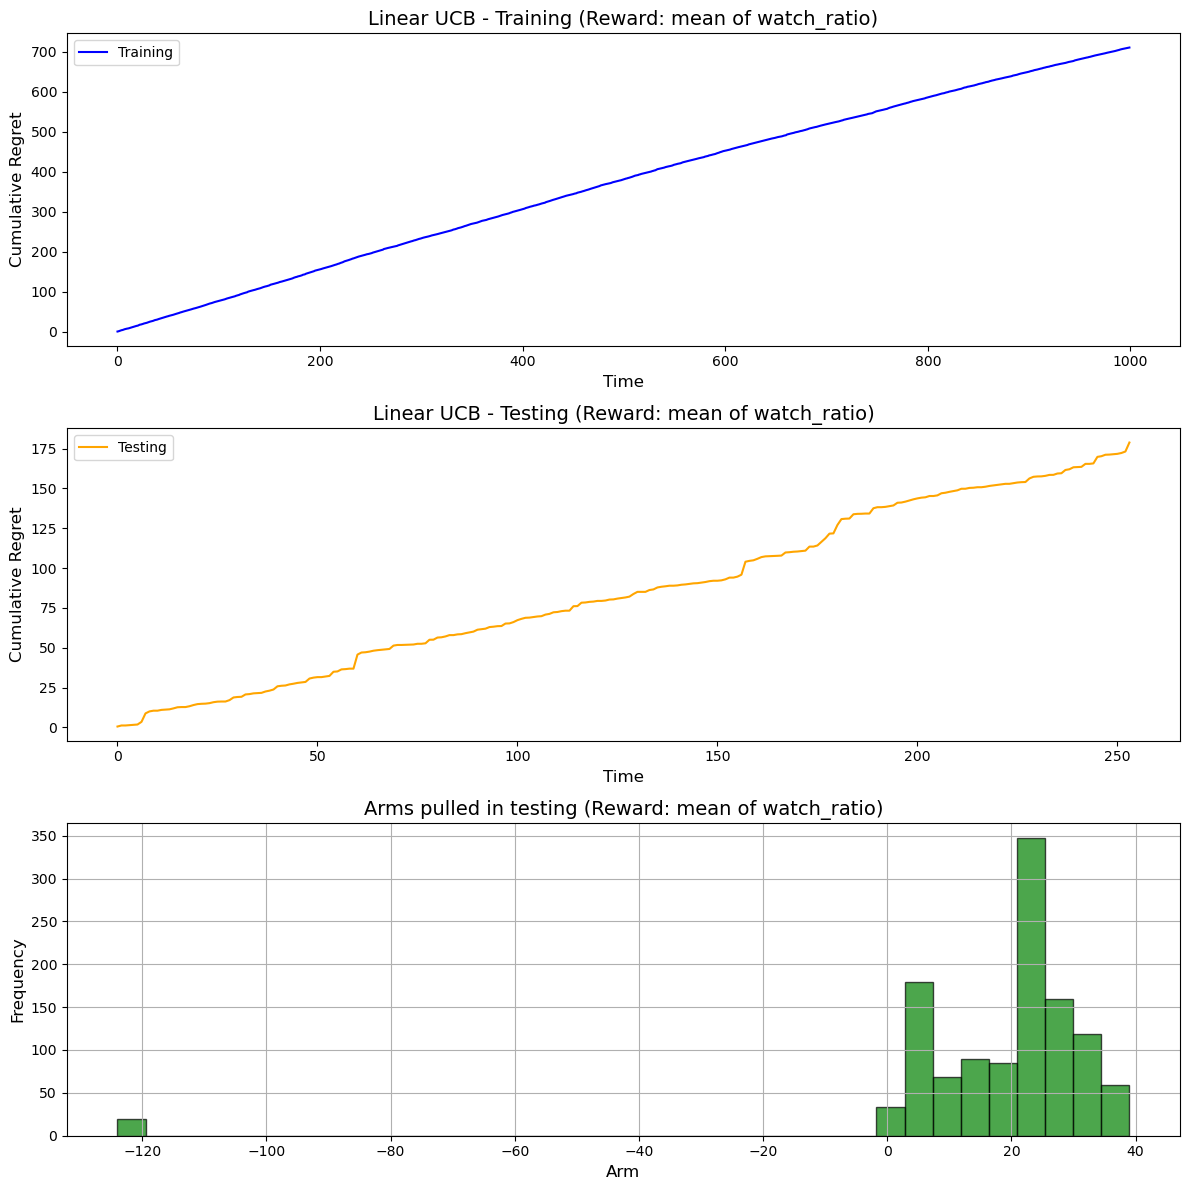

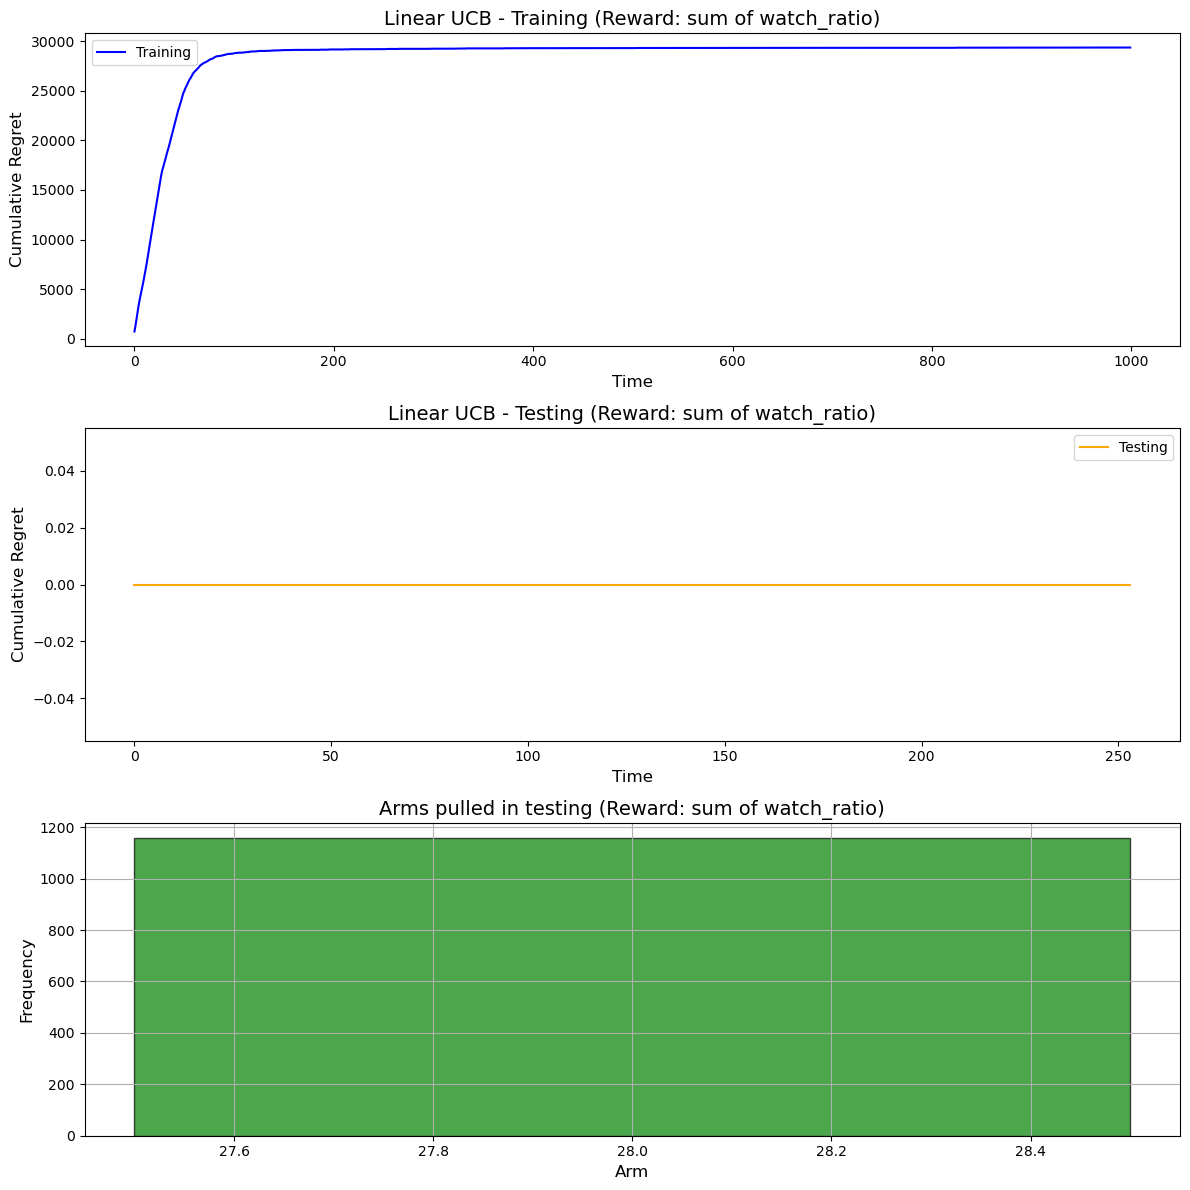

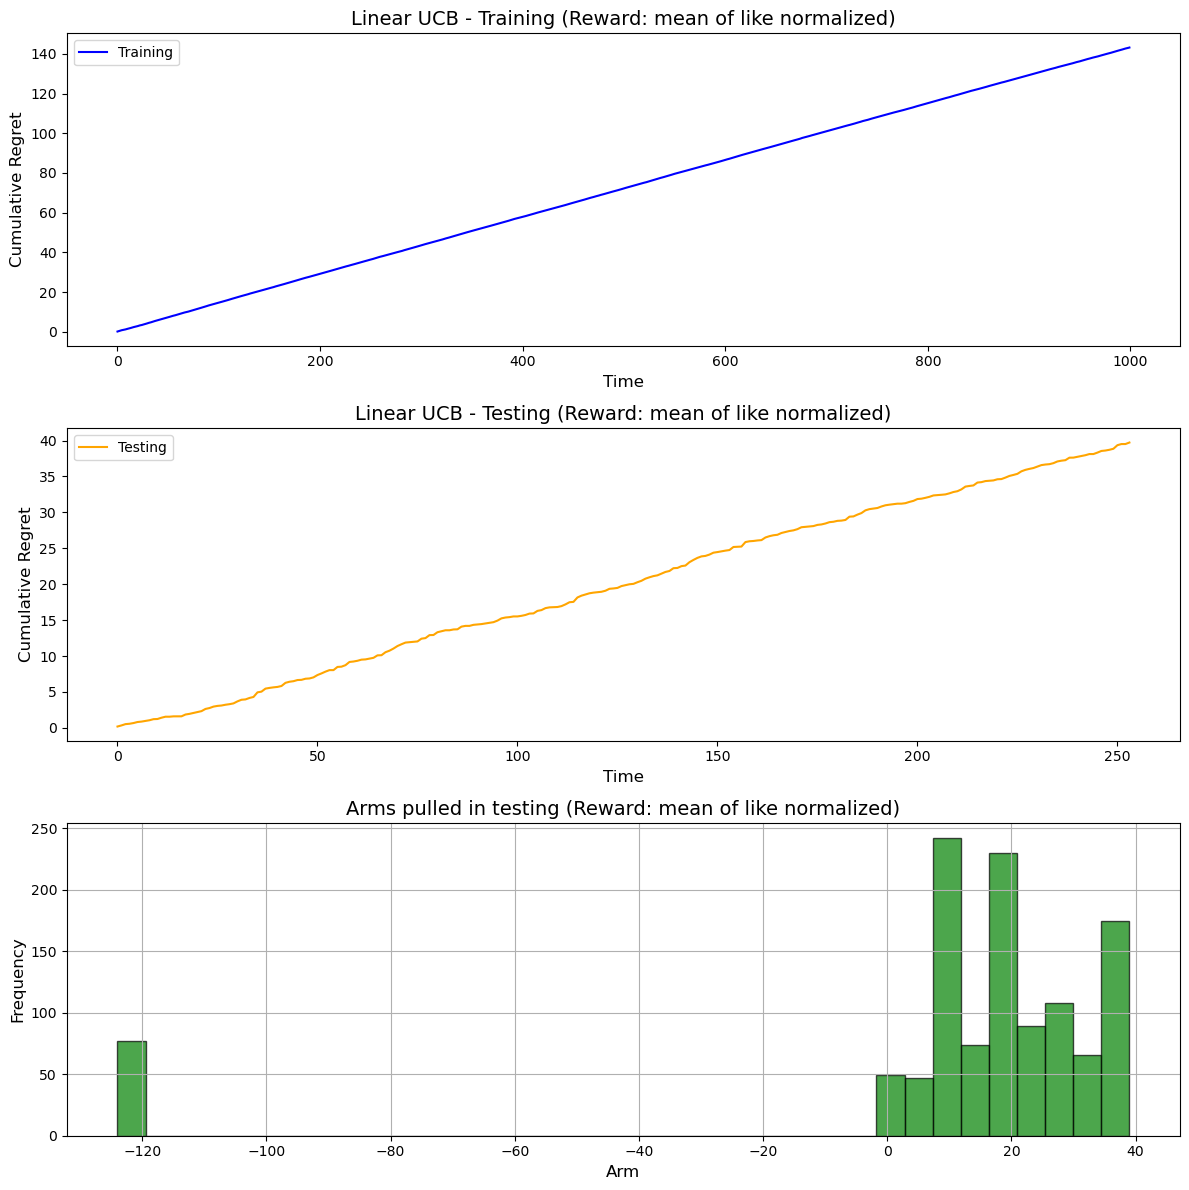

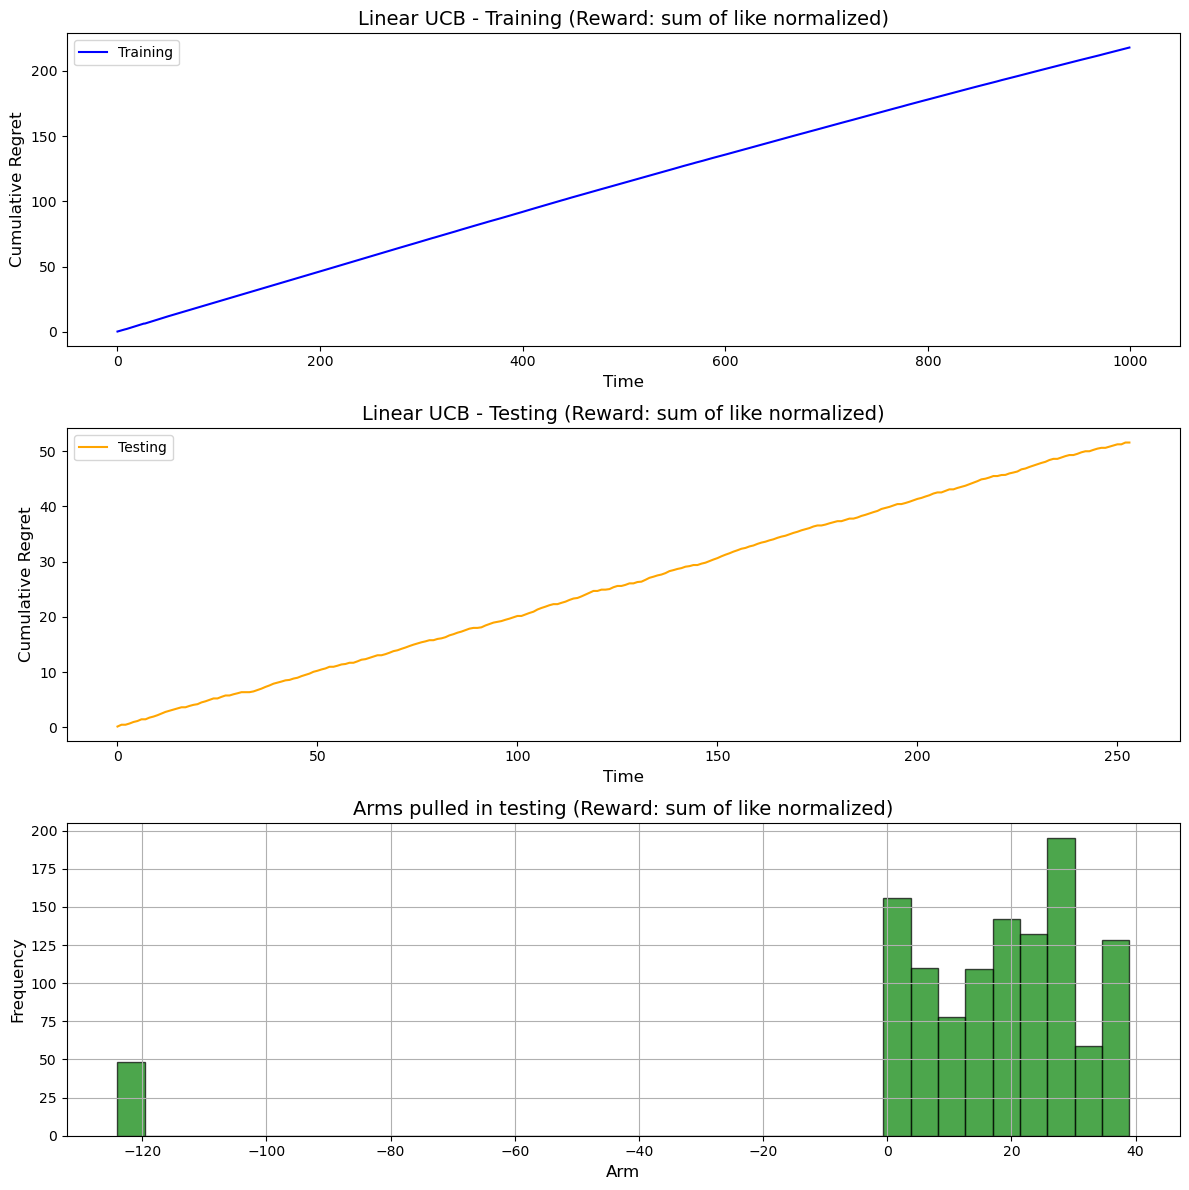

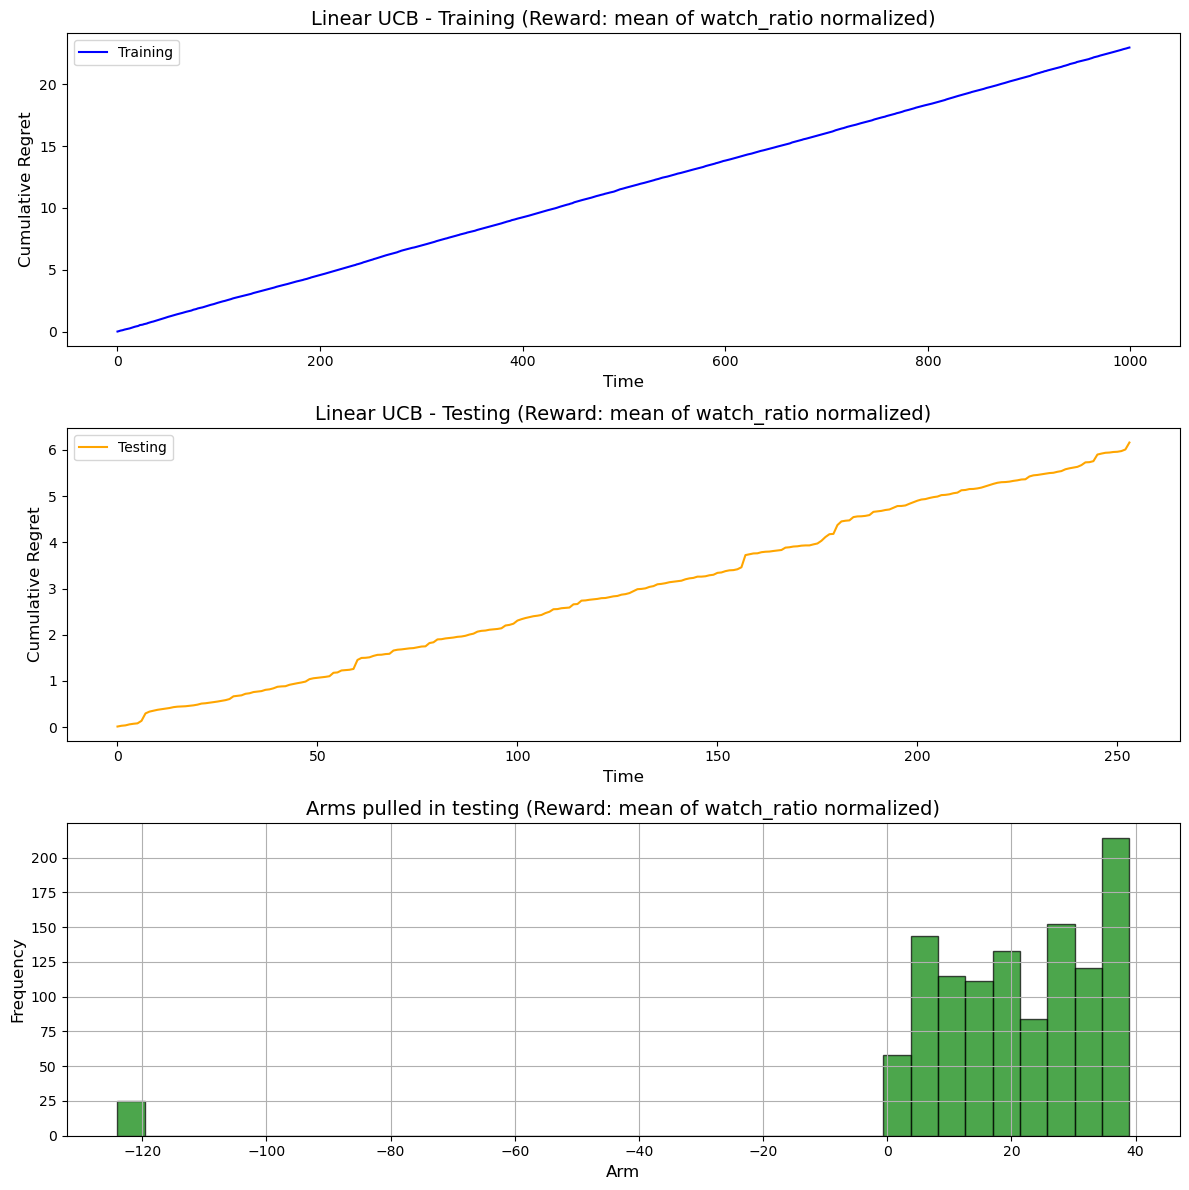

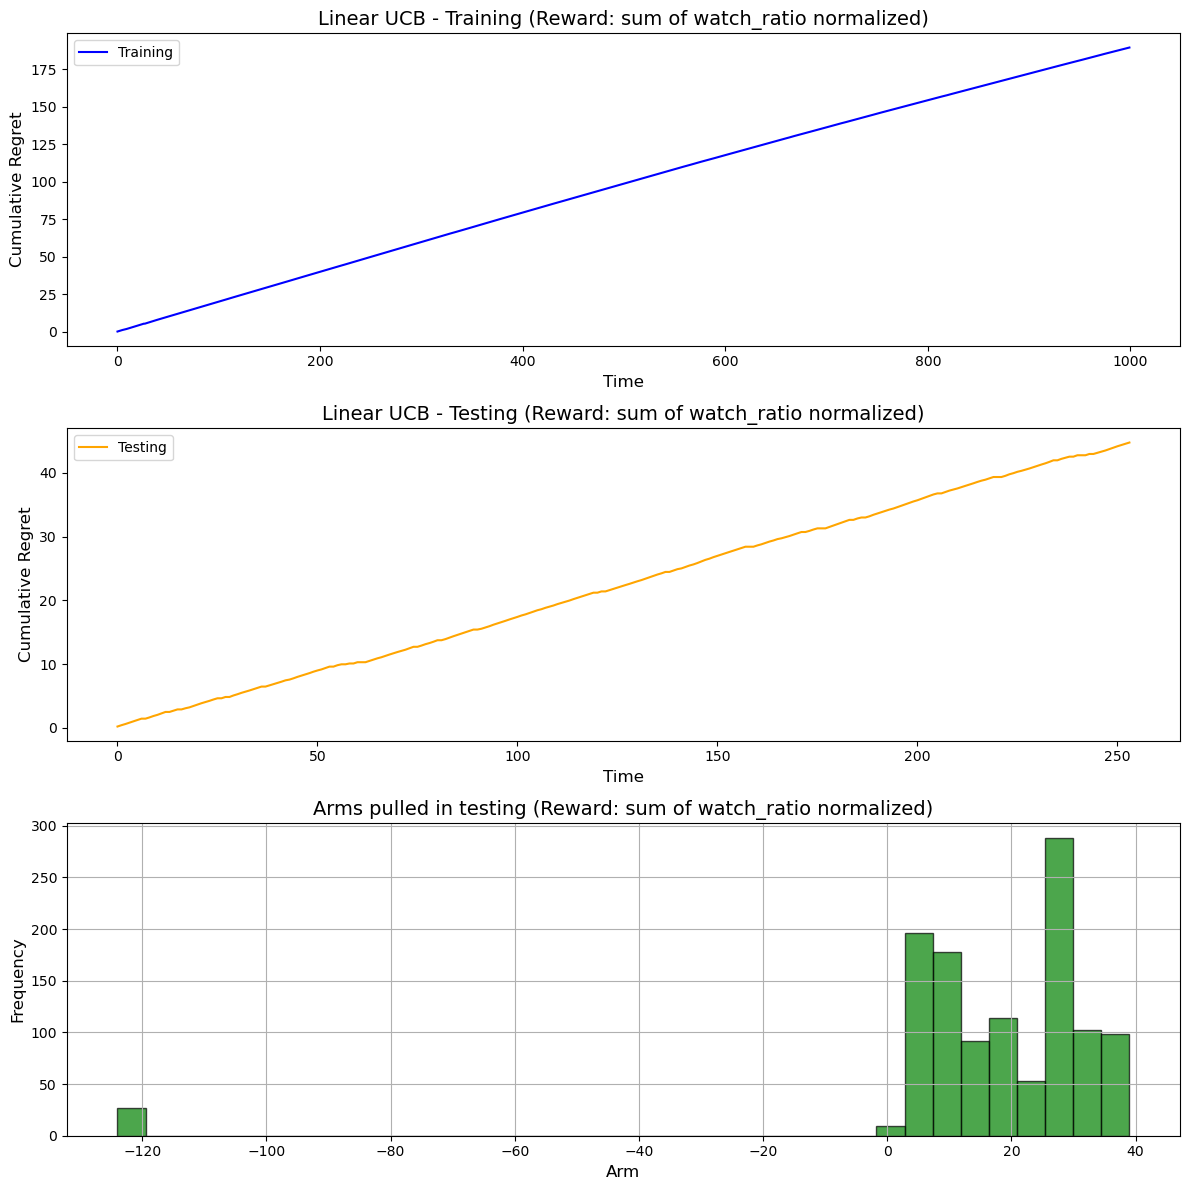

In [406]:
for i in range(4):
    train_and_test(X_train[i], X_test[i], transformed_dfs_label[i], trials = 1000, sims = 50, alpha = 1)
for i in range(4):
    train_and_test(X_train_normalized[i], X_test_normalized[i], transformed_normalized_dfs_label[i], trials = 1000, sims = 50, alpha = 1)

# 2. First level + second level category prediction (only sum of watch_ratio): 144 arms

In [220]:
# Create a reward dataframe with reward defined as sum of watch_ratio

# Group by user_id and category pairs, then sum watch_ratio. Any combination of first and second level categories are counted as on category
grouped_df = small_matrix_merged.groupby(
    ['user_id', 'first_level_category_id', 'second_level_category_id']
)['watch_ratio'].sum().reset_index()

# Create a pivot table (reward dataframe) with first and second level-category pairs as columns
small_transformed_df2 = grouped_df.pivot_table(
    index='user_id',
    columns=['first_level_category_id', 'second_level_category_id'],
    values='watch_ratio',
    fill_value=0 
)

# change column name
small_transformed_df2.columns = [f"({col[0]},{col[1]})" for col in small_transformed_df2.columns]

# Reset index to make user_id a column
small_transformed_df2 = small_transformed_df2.reset_index()

In [221]:
small_transformed_df2.head()

,user_id,"(-124.0,-124.0)","(1.0,-124.0)","(1.0,718.0)","(1.0,719.0)","(1.0,720.0)","(1.0,721.0)","(1.0,722.0)","(1.0,723.0)","(2.0,-124.0)",...,"(36.0,372.0)","(36.0,373.0)","(36.0,748.0)","(37.0,-124.0)","(37.0,317.0)","(37.0,318.0)","(37.0,341.0)","(38.0,-124.0)","(39.0,-124.0)","(39.0,698.0)"
0,14,4.286082,37.608628,2.776621,3.371029,5.320639,17.945586,12.362241,63.729829,5.342081,...,0.082083,4.118019,0.843743,7.646623,0.737833,1.449041,0.238754,2.747260,13.777285,2.427430
1,19,2.181404,27.229463,2.296181,3.363054,4.570936,15.882657,12.755549,48.666296,4.589774,...,0.053897,3.145422,0.881039,6.027500,1.084167,0.734195,0.096454,1.003059,4.356099,1.863915
2,21,2.926339,30.120902,2.615193,5.234848,4.514177,17.235987,12.396668,51.992283,10.126784,...,0.053255,3.841313,0.940724,7.312343,1.882333,0.664556,0.162728,1.276294,5.005431,1.756513
3,23,3.981672,30.196691,2.104505,1.850577,6.656162,18.508328,9.432063,38.319030,6.224574,...,0.079872,3.503311,0.812901,8.931610,0.815333,1.658226,0.144006,1.235337,2.783246,2.767548
4,24,2.684146,19.685241,2.614633,2.836516,5.820242,13.332890,10.435846,34.587794,3.935814,...,0.184757,2.012886,1.023059,11.201463,0.765500,0.254926,0.290877,1.326224,6.387239,1.614361


In [222]:
pairings = small_transformed_df2.columns[1:]

print(f"\nTotal number of unique pairings: {len(pairings)}")
print("Unique (first_level_category_id, second_level_category_id) pairings:")
print(list(pairings))


Total number of unique pairings: 144
Unique (first_level_category_id, second_level_category_id) pairings:
['(-124.0,-124.0)', '(1.0,-124.0)', '(1.0,718.0)', '(1.0,719.0)', '(1.0,720.0)', '(1.0,721.0)', '(1.0,722.0)', '(1.0,723.0)', '(2.0,-124.0)', '(2.0,110.0)', '(2.0,724.0)', '(2.0,725.0)', '(3.0,-124.0)', '(3.0,263.0)', '(3.0,270.0)', '(3.0,271.0)', '(3.0,272.0)', '(3.0,563.0)', '(3.0,564.0)', '(4.0,-124.0)', '(4.0,115.0)', '(4.0,118.0)', '(4.0,665.0)', '(5.0,-124.0)', '(5.0,735.0)', '(5.0,736.0)', '(5.0,737.0)', '(5.0,738.0)', '(6.0,-124.0)', '(6.0,666.0)', '(6.0,667.0)', '(7.0,-124.0)', '(7.0,126.0)', '(7.0,128.0)', '(7.0,129.0)', '(7.0,130.0)', '(7.0,389.0)', '(7.0,593.0)', '(8.0,-124.0)', '(8.0,670.0)', '(8.0,672.0)', '(8.0,673.0)', '(9.0,-124.0)', '(9.0,136.0)', '(9.0,548.0)', '(9.0,727.0)', '(10.0,-124.0)', '(10.0,728.0)', '(10.0,729.0)', '(11.0,-124.0)', '(11.0,147.0)', '(11.0,386.0)', '(11.0,701.0)', '(11.0,702.0)', '(12.0,-124.0)', '(12.0,153.0)', '(12.0,154.0)', '(12.0,155

In [223]:
# merge reward df with user_features (used as context vector)
small_transformed_merged_df2 = (
    user_features
    .merge(small_transformed_df2, on="user_id", how="right")
)

In [224]:
small_transformed_merged_df2.isna().sum()

user_id          0
onehot_feat0     0
onehot_feat1     0
onehot_feat2     0
onehot_feat3     0
                ..
(37.0,318.0)     0
(37.0,341.0)     0
(38.0,-124.0)    0
(39.0,-124.0)    0
(39.0,698.0)     0
Length: 156, dtype: int64

In [225]:
# Check for NaN values in each column
na_counts = small_transformed_merged_df2.isna().sum()
columns_with_na = na_counts[na_counts > 0]

if columns_with_na.empty:
    print("No columns have NaN values.")
else:
    print("Columns with NaN values and their counts:")
    print(columns_with_na)

No columns have NaN values.


In [226]:
small_transformed_merged_df2.set_index('user_id', inplace = True) # set 'user_id' as index

In [227]:
small_transformed_merged_df2 = add_constant(small_transformed_merged_df2) # add constant column

In [228]:
small_transformed_merged_df2.head()

,const,onehot_feat0,onehot_feat1,onehot_feat2,onehot_feat3,onehot_feat5,onehot_feat6,onehot_feat7,onehot_feat8,onehot_feat9,...,"(36.0,372.0)","(36.0,373.0)","(36.0,748.0)","(37.0,-124.0)","(37.0,317.0)","(37.0,318.0)","(37.0,341.0)","(38.0,-124.0)","(39.0,-124.0)","(39.0,698.0)"
user_id,,,,,,,,,,,,,,,,,,,,,
14,1.0,0,5,8,417,0,1,3,297,4,...,0.082083,4.118019,0.843743,7.646623,0.737833,1.449041,0.238754,2.747260,13.777285,2.427430
19,1.0,0,1,18,589,0,1,7,227,3,...,0.053897,3.145422,0.881039,6.027500,1.084167,0.734195,0.096454,1.003059,4.356099,1.863915
21,1.0,0,4,13,568,0,0,13,292,4,...,0.053255,3.841313,0.940724,7.312343,1.882333,0.664556,0.162728,1.276294,5.005431,1.756513
23,1.0,0,1,3,45,0,0,13,148,6,...,0.079872,3.503311,0.812901,8.931610,0.815333,1.658226,0.144006,1.235337,2.783246,2.767548
24,1.0,1,4,17,634,0,1,0,64,5,...,0.184757,2.012886,1.023059,11.201463,0.765500,0.254926,0.290877,1.326224,6.387239,1.614361


#### Train-Test Split

In [229]:
X_trans2 = small_transformed_merged_df2
X_trans2_train, X_trans2_test = train_test_split(X_trans2, test_size=0.18, random_state=2024, shuffle=True)

In [230]:
print(X_trans2_train.columns)

Index(['const', 'onehot_feat0', 'onehot_feat1', 'onehot_feat2', 'onehot_feat3',
       'onehot_feat5', 'onehot_feat6', 'onehot_feat7', 'onehot_feat8',
       'onehot_feat9',
       ...
       '(36.0,372.0)', '(36.0,373.0)', '(36.0,748.0)', '(37.0,-124.0)',
       '(37.0,317.0)', '(37.0,318.0)', '(37.0,341.0)', '(38.0,-124.0)',
       '(39.0,-124.0)', '(39.0,698.0)'],
      dtype='object', length=156)


In [231]:
X_trans2_train.head()

,const,onehot_feat0,onehot_feat1,onehot_feat2,onehot_feat3,onehot_feat5,onehot_feat6,onehot_feat7,onehot_feat8,onehot_feat9,...,"(36.0,372.0)","(36.0,373.0)","(36.0,748.0)","(37.0,-124.0)","(37.0,317.0)","(37.0,318.0)","(37.0,341.0)","(38.0,-124.0)","(39.0,-124.0)","(39.0,698.0)"
user_id,,,,,,,,,,,,,,,,,,,,,
5606,1.0,1,2,16,580,0,1,8,103,3,...,0.052521,1.431588,1.012094,6.347875,0.967333,0.356309,0.235595,1.258097,3.813107,1.050428
2372,1.0,1,1,17,624,0,0,33,209,3,...,0.158083,3.948238,2.619162,9.772106,1.098333,1.642265,0.069876,0.788484,4.656962,3.310089
6431,1.0,0,1,8,394,0,1,16,293,6,...,0.088821,4.013489,0.836087,12.771048,1.795167,1.187695,0.284054,1.705563,6.595566,3.205189
909,1.0,0,1,24,876,0,1,4,98,6,...,0.079715,2.641480,0.784073,5.698566,7.698500,0.712974,0.138307,0.802785,3.827625,1.309431
1653,1.0,0,1,10,468,0,1,6,123,2,...,0.052435,2.257143,1.117193,6.829980,1.052667,0.647347,0.133308,1.714305,5.450491,2.422806


In [232]:
arm2_ids = pairings
print("Number of arms:", len(arm2_ids))
print(np.sort(arm2_ids))

Number of arms: 144
['(-124.0,-124.0)' '(1.0,-124.0)' '(1.0,718.0)' '(1.0,719.0)'
 '(1.0,720.0)' '(1.0,721.0)' '(1.0,722.0)' '(1.0,723.0)' '(10.0,-124.0)'
 '(10.0,728.0)' '(10.0,729.0)' '(11.0,-124.0)' '(11.0,147.0)'
 '(11.0,386.0)' '(11.0,701.0)' '(11.0,702.0)' '(12.0,-124.0)'
 '(12.0,153.0)' '(12.0,154.0)' '(12.0,155.0)' '(12.0,292.0)'
 '(12.0,732.0)' '(13.0,-124.0)' '(13.0,733.0)' '(14.0,-124.0)'
 '(14.0,161.0)' '(14.0,162.0)' '(14.0,348.0)' '(15.0,-124.0)'
 '(15.0,167.0)' '(15.0,168.0)' '(15.0,169.0)' '(15.0,170.0)'
 '(15.0,319.0)' '(15.0,675.0)' '(16.0,-124.0)' '(16.0,179.0)'
 '(16.0,232.0)' '(17.0,-124.0)' '(17.0,233.0)' '(17.0,677.0)'
 '(17.0,678.0)' '(18.0,-124.0)' '(18.0,561.0)' '(18.0,714.0)'
 '(18.0,715.0)' '(18.0,716.0)' '(19.0,-124.0)' '(19.0,744.0)'
 '(19.0,745.0)' '(2.0,-124.0)' '(2.0,110.0)' '(2.0,724.0)' '(2.0,725.0)'
 '(20.0,-124.0)' '(20.0,195.0)' '(20.0,314.0)' '(20.0,368.0)'
 '(20.0,712.0)' '(20.0,713.0)' '(21.0,-124.0)' '(21.0,679.0)'
 '(21.0,680.0)' '(22.0,-124.0

In [233]:
print("Number of context features:", user_features.shape[1]-1)

Number of context features: 11


In [234]:
print(X_trans2_train.shape)

(1157, 156)


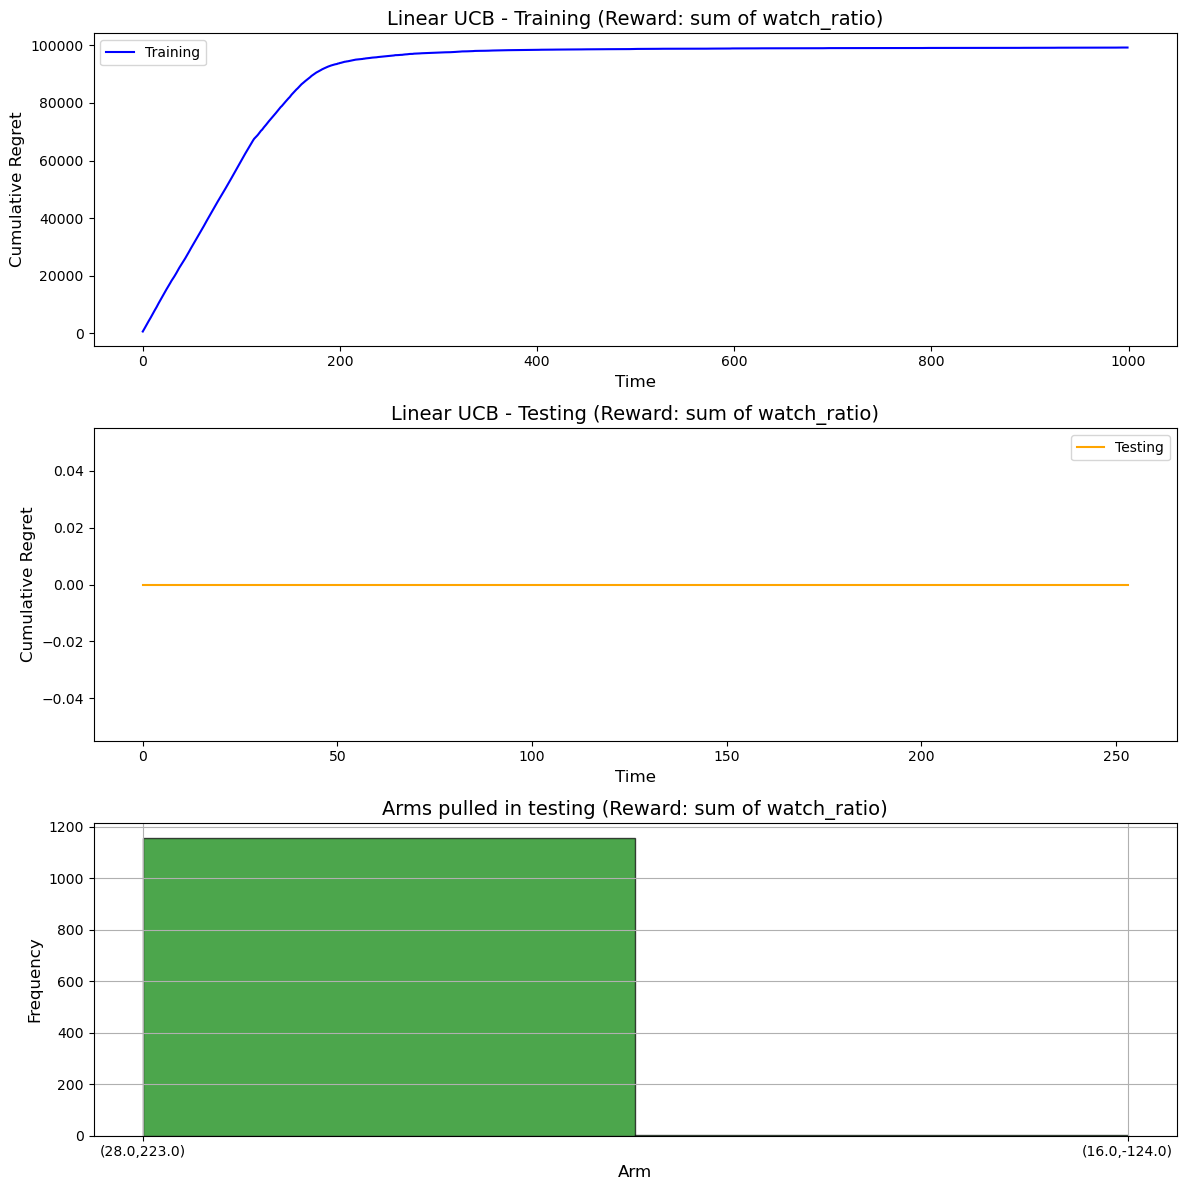

In [404]:
train_and_test(X_trans2_train, X_trans2_test, "sum of watch_ratio", num_arm = 144, num_features = 11, trials = 1000, sims = 50, alpha = 1)